In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [2]:
def percent_scaling(series):
    return (series / 100)

def cpu_scaling(series):
    return (series * 4 / 100)

def single_cpu_scaling(series):
    return (((series - 100) * (-1)) / 100)

def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

k = 151

In [3]:
def preprocess_df(cpu_df):
    cpu_df['cache_hit_rate_0'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_0']) / cpu_df['cache_hit_0']
    cpu_df['cache_hit_rate_1'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_1']) / cpu_df['cache_hit_1']
    cpu_df['cache_hit_rate_2'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_2']) / cpu_df['cache_hit_2']
    cpu_df['cache_hit_rate_3'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_3']) / cpu_df['cache_hit_3']

    cpu_df['br_miss_rate_0'] = cpu_df['br_miss_0'] / cpu_df['br_insns_0']
    cpu_df['br_miss_rate_1'] = cpu_df['br_miss_1'] / cpu_df['br_insns_1']
    cpu_df['br_miss_rate_2'] = cpu_df['br_miss_2'] / cpu_df['br_insns_2']
    cpu_df['br_miss_rate_3'] = cpu_df['br_miss_3'] / cpu_df['br_insns_3']

    cpu_df['insns_0_norm'] = cpu_df['insns_0'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['insns_1_norm'] = cpu_df['insns_1'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['insns_2_norm'] = cpu_df['insns_2'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['insns_3_norm'] = cpu_df['insns_3'] / (cpu_df['time'] - cpu_df['time'].shift())

    cpu_df['cycles_0_norm'] = cpu_df['cpu_cycles_0'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['cycles_1_norm'] = cpu_df['cpu_cycles_1'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['cycles_2_norm'] = cpu_df['cpu_cycles_2'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['cycles_3_norm'] = cpu_df['cpu_cycles_3'] / (cpu_df['time'] - cpu_df['time'].shift())

    cpu_df['bus_cycles_0_norm'] = cpu_df['bus_cycles_0'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['bus_cycles_1_norm'] = cpu_df['bus_cycles_1'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['bus_cycles_2_norm'] = cpu_df['bus_cycles_2'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['bus_cycles_3_norm'] = cpu_df['bus_cycles_3'] / (cpu_df['time'] - cpu_df['time'].shift())

    cpu_df['rd_ios_norm'] = cpu_df['rd_ios'] * 1000 / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['wr_ios_norm'] = cpu_df['wr_ios'] * 1000 / (cpu_df['time'] - cpu_df['time'].shift())

    cpu_df = cpu_df.drop(index=0)
    
    cpu_df['insns_all_norm'] = cpu_df['insns_0_norm'] + cpu_df['insns_1_norm'] + cpu_df['insns_2_norm'] + cpu_df['insns_3_norm']
    cpu_df['insns_all_norm_filt'] = signal.medfilt(cpu_df['insns_all_norm'], kernel_size=k)
    
    cpu_df['cycles_all_norm'] = cpu_df['cycles_0_norm'] + cpu_df['cycles_1_norm'] + cpu_df['cycles_2_norm'] + cpu_df['cycles_3_norm']
    
    cpu_df['current_filt'] = signal.medfilt(cpu_df['current'], kernel_size=k)

    return cpu_df

In [4]:
cpu_df = pd.read_csv('../results/numa-matrix.csv')

cpu_df['rd_ios'] = 0
cpu_df['wr_ios'] = 0

cpu_df = preprocess_df(cpu_df)

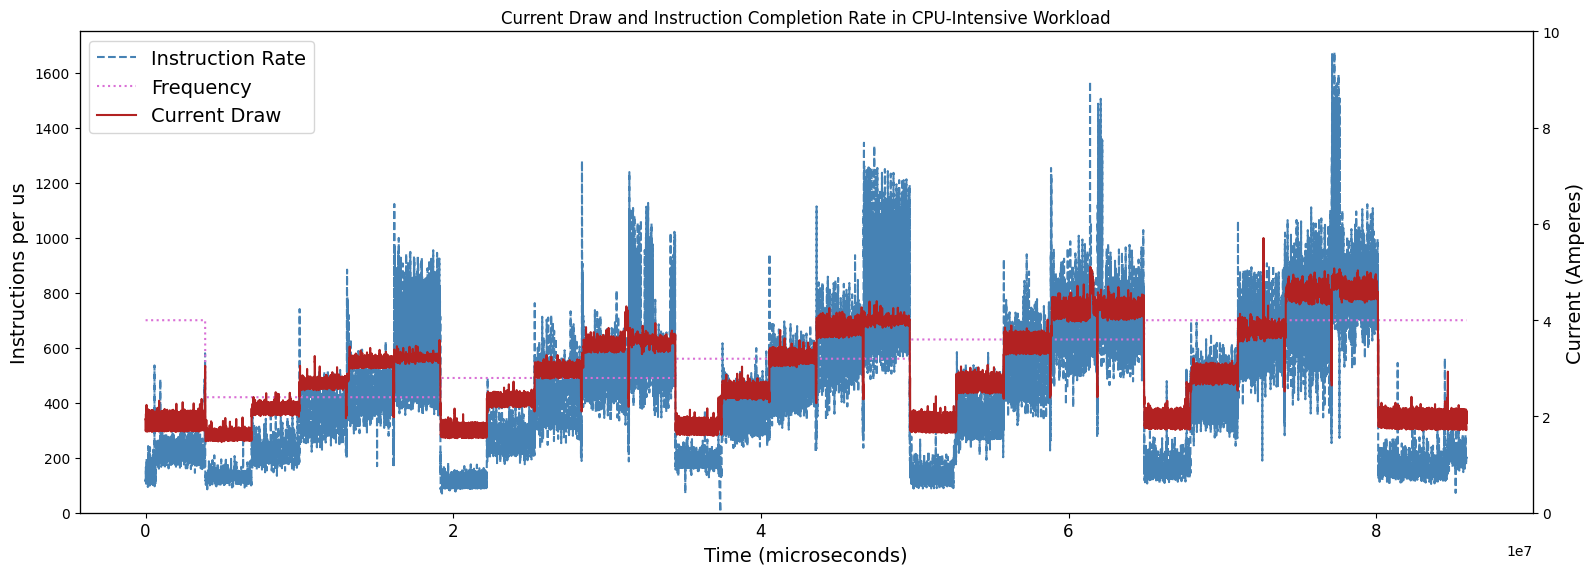

In [10]:
ax = cpu_df.plot(x='time', y='insns_all_norm', color='steelblue', linestyle='dashed', figsize=(18.75,6.25))
ax.set_ylim([0, 1750])
ax.set(xlabel='Time (microseconds)', ylabel='Instructions per us')
ax.get_legend().remove()

ax2 = ax.twinx()
ax2.yaxis.set_label_position('right')
ax2.set(ylabel='')
cpu_df.plot(ax=ax2, x='time', y='freq_0', color='orchid', linestyle='dotted')
ax2.set_ylim([0, 2500000])
ax2.get_yaxis().set_visible(False)
ax2.get_legend().remove()

ax3 = ax2.twinx()
cpu_df.plot(ax=ax3, x='time', y='current', color='firebrick')
ax3.set_ylim([0, 10])
ax3.set(ylabel='Current (Amperes)')
ax3.get_legend().remove()

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax3.yaxis.label.set_size(14)

ax.tick_params(axis="x", labelsize=12)
ax2.tick_params(axis="x", labelsize=12)
ax3.tick_params(axis="x", labelsize=12)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines + lines2 + lines3, ['Instruction Rate', 'Frequency', 'Current Draw'], loc=2, prop={'size': 14})
plt.title('Current Draw and Instruction Completion Rate in CPU-Intensive Workload')

plt.savefig("sel_correlation.pdf", format="pdf", bbox_inches="tight")

In [6]:
cpu_df = pd.read_csv('../results/disk-rick.csv')

cpu_df = preprocess_df(cpu_df)

cpu_df['insns_all_norm'] = cpu_df['insns_0_norm'] + cpu_df['insns_1_norm'] + cpu_df['insns_2_norm'] + cpu_df['insns_3_norm']
cpu_df['cycles_all_norm'] = cpu_df['cycles_0_norm'] + cpu_df['cycles_1_norm'] + cpu_df['cycles_2_norm'] + cpu_df['cycles_3_norm']

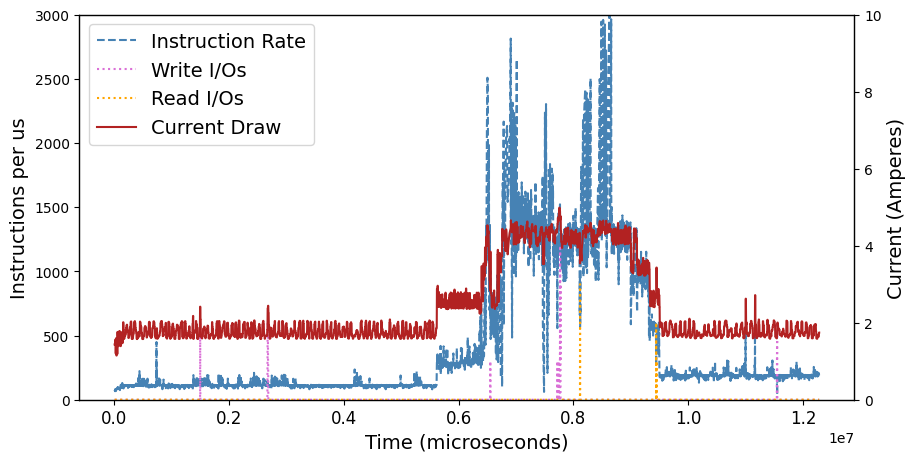

In [7]:
ax = cpu_df.plot(x='time', y='insns_all_norm', color='steelblue', linestyle='dashed', figsize=(10,5))
ax.set_ylim([0, 3000])
ax.set(xlabel='Time (microseconds)', ylabel='Instructions per us')
ax.get_legend().remove()

ax2 = ax.twinx()
ax2.yaxis.set_label_position('right')
ax2.set(ylabel='')
cpu_df.plot(ax=ax2, x='time', y='wr_ios', color='orchid', linestyle='dotted')
ax2.set_ylim([0, 10])
ax2.get_yaxis().set_visible(False)
ax2.get_legend().remove()

ax3 = ax2.twinx()
ax3.yaxis.set_label_position('right')
ax3.set(ylabel='')
cpu_df.plot(ax=ax3, x='time', y='rd_ios', color='orange', linestyle='dotted')
ax3.set_ylim([0, 10])
ax3.get_yaxis().set_visible(False)
ax3.get_legend().remove()

ax4 = ax3.twinx()
cpu_df.plot(ax=ax4, x='time', y='current', color='firebrick')
ax4.set_ylim([0, 10])
ax4.set(ylabel='Current (Amperes)')
ax4.get_legend().remove()

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax4.yaxis.label.set_size(14)

ax.tick_params(axis="x", labelsize=12)
ax2.tick_params(axis="x", labelsize=12)
ax3.tick_params(axis="x", labelsize=12)
ax4.tick_params(axis="x", labelsize=12)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax4.legend(lines + lines2 + lines3 + lines4, ['Instruction Rate', 'Write I/Os', 'Read I/Os', 'Current Draw'], loc=2, prop={'size': 14})

In [8]:
cpu_df = pd.read_csv('../results/disk-idle.csv')

cpu_df = preprocess_df(cpu_df)

cpu_df['insns_all_norm'] = cpu_df['insns_0_norm'] + cpu_df['insns_1_norm'] + cpu_df['insns_2_norm'] + cpu_df['insns_3_norm']
cpu_df['cycles_all_norm'] = cpu_df['cycles_0_norm'] + cpu_df['cycles_1_norm'] + cpu_df['cycles_2_norm'] + cpu_df['cycles_3_norm']

cpu_df.loc[70000:,'current'] += 0.08

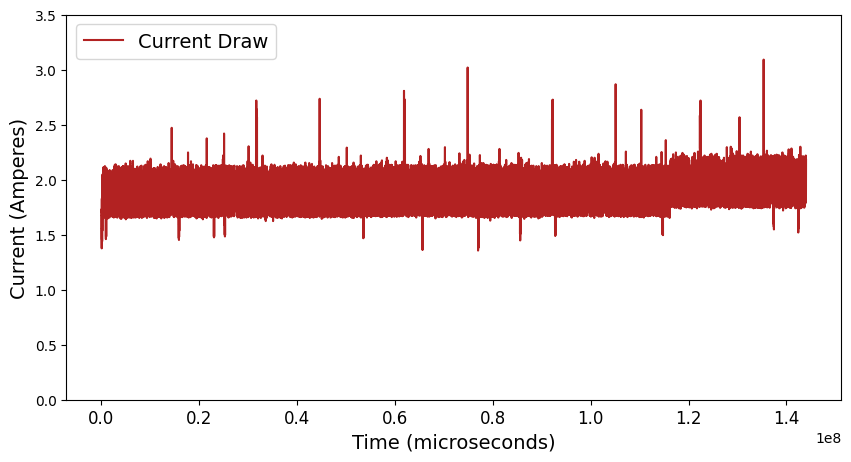

In [9]:
ax = cpu_df.plot(x='time', y='current', color='firebrick', linestyle='solid', figsize=(10,5))
ax.set_ylim([0, 3.5])
ax.set(xlabel='Time (microseconds)', ylabel='Current (Amperes)')
ax.get_legend().remove()

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

ax.tick_params(axis="x", labelsize=12)

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, ['Current Draw'], loc=2, prop={'size': 14})

In [33]:
fft_df = pd.read_csv('../results/disk-fft.csv')

fft_df = preprocess_df(fft_df)

fft_df['insns_all_norm'] = fft_df['insns_0_norm'] + fft_df['insns_1_norm'] + fft_df['insns_2_norm'] + fft_df['insns_3_norm']
fft_df['cycles_all_norm'] = fft_df['cycles_0_norm'] + fft_df['cycles_1_norm'] + fft_df['cycles_2_norm'] + fft_df['cycles_3_norm']

fft_df['current_lim'] = 3.5

#fft_df.loc[15000:,'current'] += 0.1

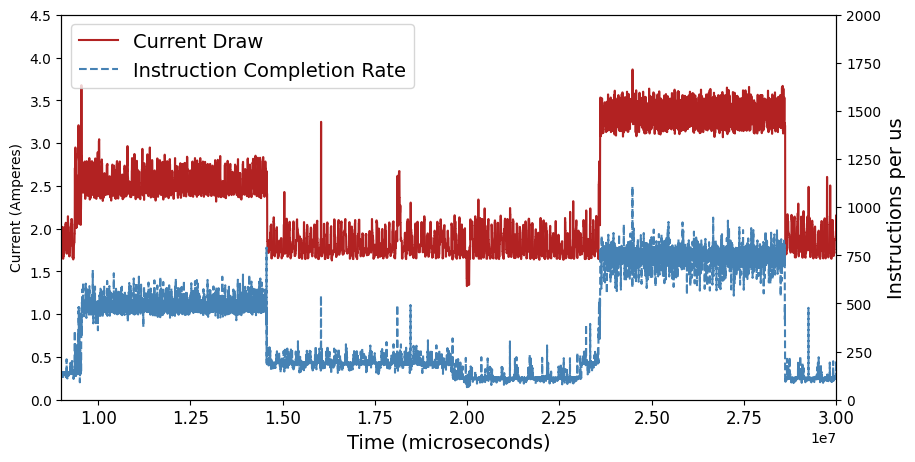

In [34]:
ax = fft_df.plot(x='time', y='current', color='firebrick', figsize=(10,5))
ax.set_xlim([9000000, 30000000])
ax.set_ylim([0, 4.5])
ax.set(xlabel='Time (microseconds)', ylabel='Current (Amperes)')
ax.get_legend().remove()

ax2 = ax.twinx()
ax2.yaxis.set_label_position('right')
ax2.set(ylabel='')
fft_df.plot(ax=ax2, x='time', y='insns_all_norm', color='steelblue', linestyle='dashed', figsize=(10,5))
ax2.set_ylim([0, 2000])
ax2.set(xlabel='Time (microseconds)', ylabel='Instructions per us')
ax2.get_legend().remove()

ax.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)

ax.tick_params(axis="x", labelsize=12)
ax2.tick_params(axis="x", labelsize=12)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, ['Current Draw', 'Instruction Completion Rate'], loc=2, prop={'size': 14})

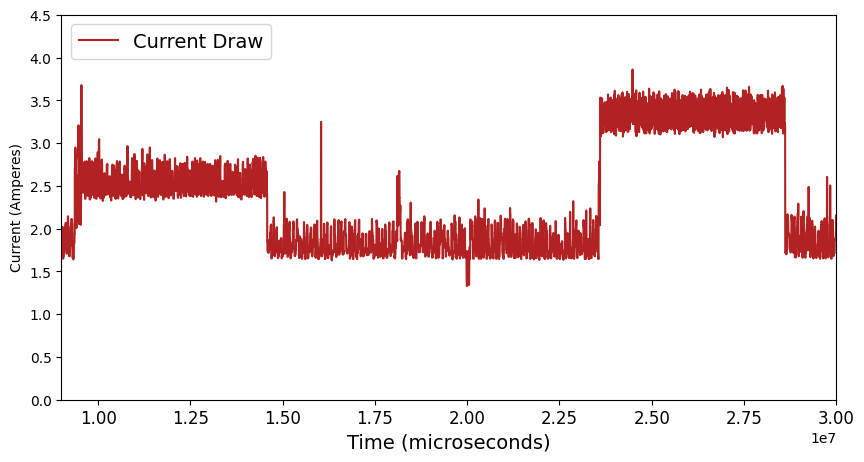

In [35]:
ax = fft_df.plot(x='time', y='current', color='firebrick', figsize=(10,5))
ax.set_xlim([9000000, 30000000])
ax.set_ylim([0, 4.5])
ax.set(xlabel='Time (microseconds)', ylabel='Current (Amperes)')
ax.get_legend().remove()

ax.xaxis.label.set_size(14)

ax.tick_params(axis="x", labelsize=12)

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, ['Current Draw'], loc=2, prop={'size': 14})